In this notebook I'm going to analyse the Mall Customer Segmentation dataset. Imagine that you own a mall and you want to discover potential customer groups so that the sense can be given to marketing team and plan the strategy accordingly. 

The dataset consists of some basic data about your customers like: Customer ID, age, gender, annual income and spending score. The spending Score is assigned to the customers based on your defined parameters like customer behavior and purchasing data.


In [27]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

['Mall_Customers.csv']


# Preprocessing

In [28]:
#loading dataset and print information
df = pd.read_csv('../input/Mall_Customers.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
CustomerID                200 non-null int64
Gender                    200 non-null object
Age                       200 non-null int64
Annual Income (k$)        200 non-null int64
Spending Score (1-100)    200 non-null int64
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [29]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


From the description of the dataset we can see that there are no missing values and that all the columns are in numerical value, except for Gender. 

The dataset provides the spending score of customers between 18-70 years old with incomes ranging from 18.000 to 137.000 dollars/year.

The spending score is equally distributed and it ranges between 1 and 99

The CustomerID column is just another index for the customers, it doesn't provide any value so can be removed.

Finally, let's simplify the name of the columns so that it is easier to retrieve them later on.

In [30]:
del df['CustomerID']
df.columns=['Gender', 'Age', 'AnnualIncome', 'SpendingScore']
df.head()

,Gender,Age,AnnualIncome,SpendingScore
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


Next, let's encode the Gender column from Male,Female to into integers 1,0 because makes life easier working with numbers

In [31]:
df['Gender'] = (df['Gender'] =='Male').astype(int)
df.head()

,Gender,Age,AnnualIncome,SpendingScore
0,1,19,15,39
1,1,21,15,81
2,0,20,16,6
3,0,23,16,77
4,0,31,17,40


# Analysis

Now that the dataset has been preprocessed, let's analyze it by applying PCA in order to see how the customers are distibuted in a lower dimensional space which is possible to visualize.

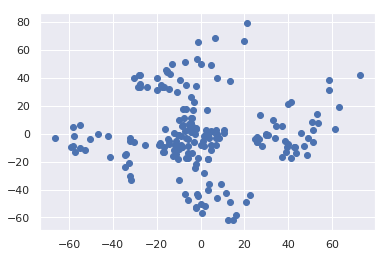

In [32]:
#map dataset from 4 to 2 dimensions
pca=PCA(n_components=2)
data=np.asarray(df)
pca.fit(data)
X=pca.transform(data)

plt.scatter(X[:,0], X[:,1])

We can notice that the points are distributed around 5 clusters. Using KMeans, let's assign to each example the cluster to which the customer belongs it. Here the result

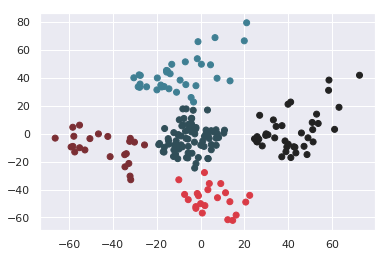

In [33]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(X)

fig, ax = plt.subplots(1, 1)
scatter=ax.scatter(X[:,0], X[:,1], c=kmeans.labels_, cmap=sns.diverging_palette(220, 10, as_cmap=True, center="dark"))

This representation allows to see how the datapoints are clustered but it is missing to explain which features are responsible for these clusters. In other words, what are the features that distinguish these clusters?

First, let's assign each datapoint to its cluster which is a number between 0 and 4

In [34]:
df['Group']=pd.Series(kmeans.labels_, df.index)
df.head()

,Gender,Age,AnnualIncome,SpendingScore,Group
0,1,19,15,39,3
1,1,21,15,81,4
2,0,20,16,6,3
3,0,23,16,77,4
4,0,31,17,40,3


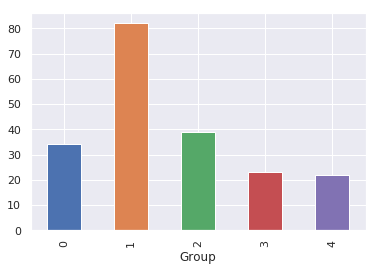

In [35]:
df.groupby('Group').count().iloc[:,0].plot(kind='bar')

In [36]:
df.groupby('Group').mean()

,Gender,Age,AnnualIncome,SpendingScore
Group,,,,
0,0.558824,41.647059,88.735294,16.764706
1,0.402439,42.475610,55.475610,49.268293
2,0.461538,32.692308,86.538462,82.128205
3,0.391304,45.217391,26.304348,20.913043
4,0.409091,25.272727,25.727273,79.363636


We can see that there are groups 4 and 2 which represent customers with a spending score around 80 points. Interestingly, from these two groups we can see that a high spending score is not associated to a high annual income. In addition, these two groups are characterized by young people (25 and 32 years old average) and by a prevalence of female customers. 

Generally, groups with people more than 40 years old tend to have a lower spending score.
Group 1 which represents 40 years old people with an average annual income of 55k have a spending score in the middle around 50.

Group 0 which is the only one with a prevalence of men (56%) represents the lower spending score.  

So, from this first quick analysis seems that young people have an higher spending score. On the other hand, old people (specially men) tend to have a low spending score. Interestingly, the spending score is affected more by the age of the customer instead of its annual income. 

Based on these first insights, let's play around with the customer's age. I decided to divide the customers into 3 categories:
1. 18-25 students
2. 25-40 adults
3. 40-70 elders

In [37]:
ageGroup=[]

for age in df['Age']:
    if age<=25:
        index=0
    elif age<=40:
        index=1
    else:
        index=2
    ageGroup.append(index)

df['AgeGroup']=pd.Series(ageGroup, df.index)

In [38]:
df.groupby('AgeGroup').mean()

,Gender,Age,AnnualIncome,SpendingScore,Group
AgeGroup,,,,,
0,0.473684,21.157895,45.684211,54.947368,2.184211
1,0.416667,33.059524,69.107143,61.261905,1.761905
2,0.448718,53.705128,58.602564,35.974359,1.102564


Text(0.5, 0, 'Annual Income')

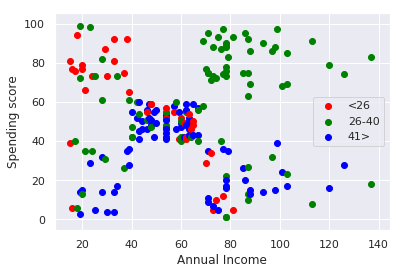

In [39]:
data=np.asarray(df[['AnnualIncome', 'SpendingScore']])
colors=['red','green', 'blue']
uniquePoints={}
fig, ax = plt.subplots(1, 1)
for idx, example in enumerate(data):
    label=ageGroup[idx]
    point=ax.scatter(example[0], example[1], c=colors[label], label=label)
    uniquePoints[label]=point
    

ax.legend([uniquePoints[key] for key in uniquePoints],['<26', '26-40', '41>'])
ax.set_ylabel("Spending score")
ax.set_xlabel("Annual Income")

As already found, elders tend to have a lower spending score compared to younger people. We can see that there is a prevalence of adults (26-40 years old) with a high spending score and a high annual income as well.

Let's plot these three age groups by spending score and annual income. Here students have a spending score close to the adults even if their annual income is the lowest among the age groups.

Text(0.5, 1.0, 'Annual income')

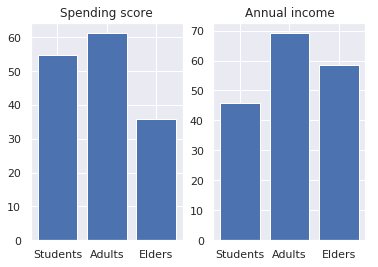

In [40]:
fig, ax = plt.subplots(1, 2)
ax[0].bar([i for i in range(3)], df.groupby('AgeGroup').mean()['SpendingScore'].tolist(), tick_label=['Students', 'Adults', 'Elders'])
ax[0].set_title('Spending score')
ax[1].bar([i for i in range(3)], df.groupby('AgeGroup').mean()['AnnualIncome'].tolist(), tick_label=['Students', 'Adults', 'Elders'])
ax[1].set_title('Annual income')

Let's see how the situation changes when the customers are divided by gender

Text(0.5, 1.0, 'Annual Income')

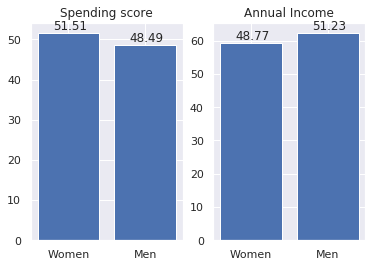

In [41]:
spendingScore=df.groupby('Gender').mean()['SpendingScore'].tolist()
annualIncome=df.groupby('Gender').mean()['AnnualIncome'].tolist()

fig, ax = plt.subplots(1, 2)
ax[0].bar([i for i in range(2)], spendingScore, tick_label=['Women', 'Men'])
tot=np.sum(spendingScore)
for i in range(2):
    ax[0].text(i-0.2, spendingScore[i]+1, '{:.2f}'.format(spendingScore[i]/tot*100))
ax[0].set_title('Spending score')

ax[1].bar([i for i in range(2)], annualIncome, tick_label=['Women', 'Men'])
tot=np.sum(annualIncome)
for i in range(2):
    ax[1].text(i-0.2, annualIncome[i]+1, '{:.2f}'.format(annualIncome[i]/tot*100))
ax[1].set_title('Annual Income')

Women account for the 51% of the total spending score compared to men although their annual income accounts only the 49% of the total. The difference is negligeble and it could be caused by the sample size of the dataset. 

Let's move on analyzing the relationship between each feature.

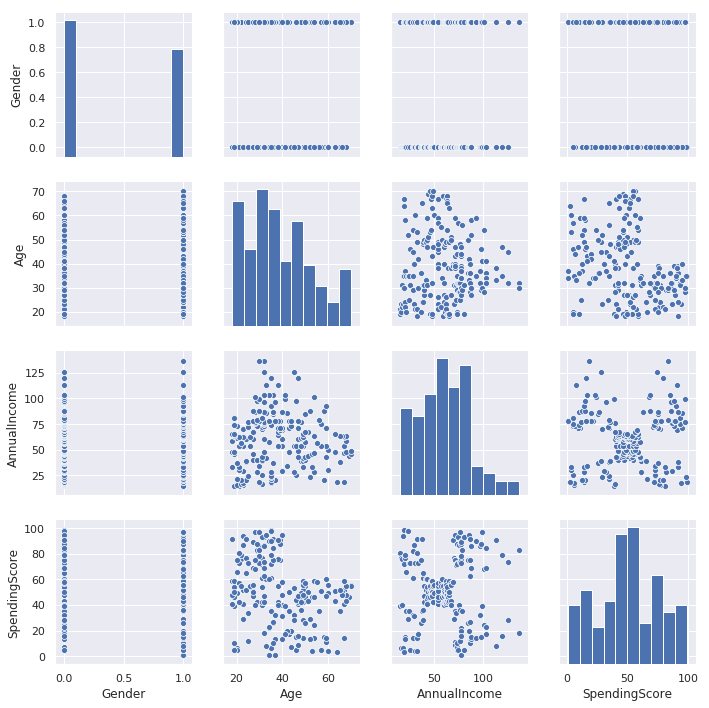

In [42]:
sns.pairplot(df[['Gender', 'Age', 'AnnualIncome', 'SpendingScore']])

From here we can see that the dataset is skewed towards young people with a small percentege of elders. Moreover, the dataset fails to represent rich people's behaviour due to the fact that the distribution of incomes is shifted toward average-low annual incomes.

AnnualIncome-SpendingScore plot resemble the distribution obtained from PCA analysis probably meaning that Annual Income and Spending score provide the higher variance in the dataset.

In [43]:
#Variance of each feature
var = df[['Gender', 'Age', 'AnnualIncome', 'SpendingScore']].var()
print(var)

Gender             0.247638
Age              195.133166
AnnualIncome     689.835578
SpendingScore    666.854271
dtype: float64


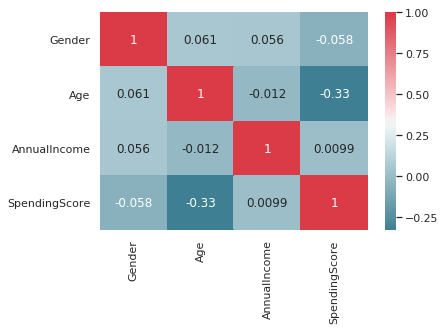

In [44]:
corr = df[['Gender', 'Age', 'AnnualIncome', 'SpendingScore']].corr()

sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 10, as_cmap=True))

The heatmap shows no correlation between gender and spending score which confirms the previous findings.
There is another evidence for the fact that the spending score is correlated with age. Although the correlation is too low to have some heavy significance, it is interesting to see that the spending score decreases with age. 

# Predicting Spending Score

Now, suppose that a new customer has been registered and its spending score is not available yet. Can we predict its spending score?

Let's start by importing the models and preparing the data. Because I have a limited number of examples, I opted for a cross-validation metric instead of just splitting the dataset in train and test.

In [45]:
from sklearn.linear_model import LinearRegression
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve
from sklearn.dummy import DummyRegressor

X=np.asarray(df[['Gender', 'Age', 'AnnualIncome']])
Y=np.asarray(df['SpendingScore'])
#x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=0)

In [46]:
print('Dummy Regressor:')
dumModelout=cross_val_score(DummyRegressor(strategy='mean'), X, Y, cv=5)
#r^2 score
print('Dummy model score: {:.2f} (+/- {:.2f})'.format(dumModelout.mean(), dumModelout.std()**2))
print('\n')
print('Linear regression:')
outLR=cross_val_score(LinearRegression(normalize=True), X, Y, cv=5)
print('Linear model score: {:.2f} (+/- {:.2f})'.format(outLR.mean(), outLR.std()**2))


Dummy Regressor:
Dummy model score: -0.01 (+/- 0.00)


Linear regression:
Linear model score: -1.60 (+/- 7.37)


In [ ]:
print('Support Vector Regression')
#Parameters to experiment with
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

clf = GridSearchCV(svm.SVR(), tuned_parameters, return_train_score=True, cv=5).fit(X,Y)
print('Best model\'s params:', clf.best_params_)
#print(clf.cv_results_.keys())
print('Train score: {:.2f} (+/- {:.2f})'.format(clf.cv_results_['mean_train_score'].mean(), clf.cv_results_['std_train_score'].mean()))
print('Test score: {:.2f}  (+/- {:.2f})'.format(clf.cv_results_['mean_test_score'].mean(), clf.cv_results_['std_test_score'].mean()))

optimised_clf= clf.best_estimator_

Support Vector Regression


First, a dummy classifier is used to set a baseline from which we can assess the quality of the predictions. This classifier uses the mean of the target feature as prediction. So, the other models must score higher than this model in order to be usefull to predict the spending score.

Unfortunately, both models (linear regression and support vector regression) performed worse than the baseline. In fact, both models results have a r^2 score below 0 which means that their prediction diverge from the correct answer more than using the average.

Solutions that could be used to improve the predictions could be:
* Use models ensemble 
* Increasing dataset by collecting more data or noise-generating new datapoints

# Conclusion

In conclusion, the data provided interesting insights about potential customer groups. From a group-age point of view, elders are the ones that have a lower spending score altough their annual income is on the average. Adults have the higher spending score and as well the higher annual income. Students have a high spending score, close to the Adults although their spending score is lower than the Elders.

> From a gender prospective, women spend more than men although their income is lower although there is not enough data to confirm this.

Moving to customer groups, from the analysis we can extrapolate 5 clusters:

Group 0: Men adults (40y) with an high income (88k) and a low spending score (20) (unhappy)

Group 1: Women adults with average income (55k) and average spending score (50) (moderate)

Group 2: Adults with high income and high spending score (80) (buyers)

Group 3: Women adults with low income (26k) and low spending score (20) (savers)

Group 4: Students (mostly women) with low income but high spending score (80)


Assuming a strategy that mainly targets customers with high incomes (potential buyers), the mall should focus on group 0 and group 2. While group 0 could represent unhappy clients on which a deeper analysis about the reasons is required, group 2 represents regular customers and the main source of income for the mall. 

Interestingly, group 0 may be seen as potential group 2 customers. In fact, with more data and an analysis about the reasons of the low spending score may be possible to develop a targeted market campaign to convert customers from group 0 to group 2.  

People in group 1 are not the main source of profit for the mall, but there is potential for profit. With an appropriate data a campaign could be used to increase their spending score. 

Group 3 represents savers. People with a low income that spend their money wise. The mall should not be interested in this category. 

Group 4 describes mainly students which have a low income but high spending score. Due to the low income, a targeted campaign may not have the potential to increase the spending score. However, it is important to keep these customers as satisfied as possible.

In addition, the mall should provide the products focusing on people ranging 18-40 which have a spending score double then elders in order to increase the revenues.
